In [1]:
# !pip install datasets

In [2]:
import os
from dotenv import load_dotenv; load_dotenv()

from tqdm.notebook import tqdm
import pickle
import pandas as pd
import polars as pl
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import json

from datasets import load_dataset

os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
import torch
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from src.helpers import preprocessing as preproc
from src.helpers.postprocessing import get_top_k_representative_docs, from_list_to_string, safe_json_load
from src.helpers.sentiment_analysis import SentimentModel
from src.topol_modeling import TopolModeling as TOPOL
from sknetwork.clustering import Leiden
from scipy.sparse import csr_matrix
from src.openai_api import OPENAI_CLIENT, OpenAIEmbedding
from src.openai_api import chat_completion as openai_chat_completion
from src.google_ai_api import GGENAI_CLIENT, GoogleAIEmbedding, AdvancedGoogleAIEmbedding
from src.google_ai_api import chat_completion as google_chat_completion

In [3]:
DATA_PATH = os.getenv("DATA_PATH")
OUTPUTS_PATH = os.path.join(os.getenv("OUTPUTS_PATH"), "robustness_checks", "rb1")

DEVICE = torch.device("mps")
STOP_WORDS = list(ENGLISH_STOP_WORDS)
RANDOM_STATE = 42

---

# Getting data

In [4]:
dataset = load_dataset("amazon_polarity")
FILES_PREFIX = "amazon_reviews"

# dataset = load_dataset("yelp_review_full")
# FILES_PREFIX = "yelp_reviews"

# dataset = load_dataset("imdb")
# FILES_PREFIX = "imdb_reviews"

# dataset = load_dataset("google_play_store_reviews")
# FILES_PREFIX = "google_play_store_reviews"

In [5]:
X_train = [f"{title} {text}" for title, text in zip(dataset['train']['title'], dataset['train']['content'])]
X_test = [f"{title} {text}" for title, text in zip(dataset['test']['title'], dataset['test']['content'])]

y_train = dataset['train']['label']
y_test = dataset['test']['label']

# X = X_train + X_test
# y = y_train + y_test

data = pd.DataFrame({ 'text': X_train, 'label': y_train })

In [6]:
N_SAMPLE = 5000

df_A = data[data['label'] == 1].sample(N_SAMPLE, random_state=RANDOM_STATE)
df_B = data[data['label'] == 0].sample(N_SAMPLE, random_state=RANDOM_STATE)
df = pd.concat([df_A, df_B], axis=0).reset_index(drop=True)

In [7]:
print(len(df[df["label"] == 0]), len(df[df["label"] == 1]))
df

5000 5000


,text,label
0,Perfect Mantra I've been looking for this mant...,1
1,Quality I'm just a little disapointed with the...,1
2,Exceptional murder-mystery writer scores big. ...,1
3,all the prodding questions you never wanted to...,1
4,Best Wok ever I am so glad I bought this wok. ...,1
...,...,...
9995,Doesn't work for me While I applaud the focus ...,0
9996,Beyond Stupid One wonders about all the people...,0
9997,Buyer Be Very Wary The trusted leader in child...,0
9998,I'll bring earplugs to the state fair next yea...,0


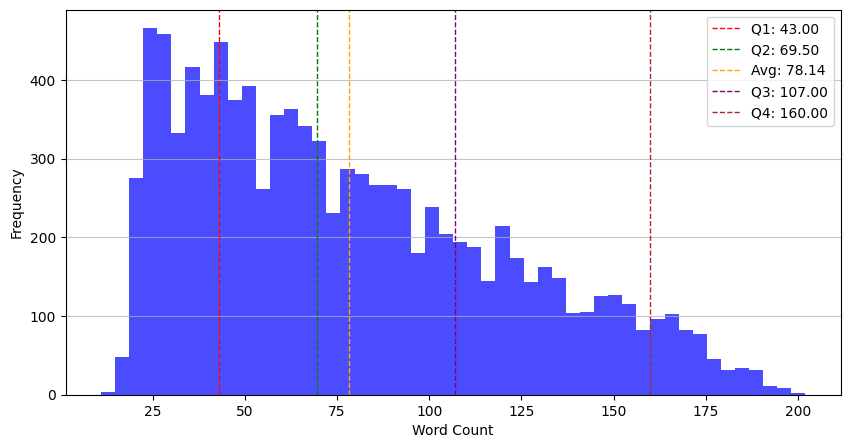

In [8]:
word_counts = df["text"].apply(lambda x: len(x.split()))
q1_word_counts = word_counts.quantile(0.25)
q2_word_counts = word_counts.quantile(0.50)
avg_word_counts = word_counts.mean()
q3_word_counts = word_counts.quantile(0.75)
q4_word_counts = word_counts.quantile(0.95)
plt.figure(figsize=(10, 5))
plt.hist(word_counts, bins=50, color='blue', alpha=0.7)
plt.axvline(q1_word_counts, color='red', linestyle='dashed', linewidth=1, label=f'Q1: {q1_word_counts:.2f}')
plt.axvline(q2_word_counts, color='green', linestyle='dashed', linewidth=1, label=f'Q2: {q2_word_counts:.2f}')
plt.axvline(avg_word_counts, color='orange', linestyle='dashed', linewidth=1, label=f'Avg: {avg_word_counts:.2f}')
plt.axvline(q3_word_counts, color='purple', linestyle='dashed', linewidth=1, label=f'Q3: {q3_word_counts:.2f}')
plt.axvline(q4_word_counts, color='brown', linestyle='dashed', linewidth=1, label=f'Q4: {q4_word_counts:.2f}')
plt.legend()
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.show()

---

# Pre-processing data

##### 1. Data cleaning

In [9]:
entities_to_mask = ["DATE", "TIME", "ORGANIZATION", "NUM", "LOCATION"]
STOP_WORDS += entities_to_mask

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_texts.pickle")
if os.path.exists(fpath):
    print(f"Loading cleaned texts from {fpath}")
    with open(fpath, "rb") as f:
        texts = pickle.load(f)
    print(f"Loaded {len(texts)} texts")
else:
    print(f"Generating cleaned texts for {len(df)} raw texts...")
    texts = []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        cleaned_text = preproc.get_clean_text(row, entities_to_mask=entities_to_mask, max_lenght=5000)
        texts.append(cleaned_text)
    with open(fpath, "wb") as f:
        pickle.dump(texts, f)
    print(f"Saved {len(texts)} cleaned texts to {fpath}.")

df["text"] = texts
del fpath

Loading cleaned texts from /Users/tig1/Programming/TOPOL/data/amazon_reviews_texts.pickle
Loaded 10000 texts


##### 2. Embedding texts

In [10]:
EMBEDDING_MODEL = OpenAIEmbedding(model="text-embedding-3-small")
# EMBEDDING_MODEL = GoogleAIEmbedding(model="text-embedding-004")
# EMBEDDING_MODEL = AdvancedGoogleAIEmbedding(model='text-embedding-004', task='clustering')
# EMBEDDING_MODEL = SentenceTransformer('intfloat/multilingual-e5-large-instruct', device=DEVICE)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_embeddings.pickle")
if os.path.exists(fpath):
    print(f"Loading embeddings from {fpath}")
    with open(fpath, "rb") as f:
        embeddings = pickle.load(f)
    print(f"Loaded {len(embeddings)} embeddings")
else:
    print(f"Generating embeddings for {len(df)} text...")
    embeddings = EMBEDDING_MODEL.encode(df["text"].tolist(), fast=False)
    with open(fpath, "wb") as f:
        pickle.dump(embeddings, f)
    print(f"Saved {len(embeddings)} embeddings to {fpath}.")

df["embedding"] = embeddings.tolist()
del fpath

Loading embeddings from /Users/tig1/Programming/TOPOL/data/amazon_reviews_embeddings.pickle
Loaded 10000 embeddings


##### 3.a. Sentiment Analysis: FinBERT

In [11]:
sentiment_model = SentimentModel(model_name="ProsusAI/finbert", device=DEVICE, n_special_tokens=5)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_sentiments_finbert.pickle")
if os.path.exists(fpath):
    print(f"Loading sentiments from {fpath}")
    with open(fpath, "rb") as f:
        sentiments = pickle.load(f)
    print(f"Loaded {len(sentiments)} sentiments")
else:
    print(f"Generating sentiments for {len(df)} texts...")
    sentiments = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        doc = row['text']
        temp_sentiment = sentiment_model(doc, truncation=False)
        sentiments.append(temp_sentiment)
    with open(fpath, "wb") as f:
        pickle.dump(sentiments, f)
    print(f"Saved {len(sentiments)} sentiments to {fpath}.")

df["sentiment_finbert"] = sentiments
df["sentiment_score_finbert"] = df["sentiment_finbert"].apply(sentiment_model.get_sentiment_score)
del fpath, sentiment_model

Device set to use mps


Loading sentiments from /Users/tig1/Programming/TOPOL/data/amazon_reviews_sentiments_finbert.pickle
Loaded 10000 sentiments


##### 3.b. Sentiment Analysis: Multilingual DistilBERT

In [12]:
sentiment_model = SentimentModel(model_name="tabularisai/multilingual-sentiment-analysis", device=DEVICE, n_special_tokens=5)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_sentiments_distilbert.pickle")
if os.path.exists(fpath):
    print(f"Loading sentiments from {fpath}")
    with open(fpath, "rb") as f:
        sentiments = pickle.load(f)
    print(f"Loaded {len(sentiments)} sentiments")
else:
    print(f"Generating sentiments for {len(df)} texts...")
    sentiments = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        doc = row['text']
        temp_sentiment = sentiment_model(doc, truncation=False)
        sentiments.append(temp_sentiment)
    with open(fpath, "wb") as f:
        pickle.dump(sentiments, f)
    print(f"Saved {len(sentiments)} sentiments to {fpath}.")

df["sentiment_distilbert"] = sentiments
df["sentiment_score_distilbert"] = df["sentiment_distilbert"].apply(sentiment_model.get_sentiment_score)
del fpath, sentiment_model

Device set to use mps


Loading sentiments from /Users/tig1/Programming/TOPOL/data/amazon_reviews_sentiments_distilbert.pickle
Loaded 10000 sentiments


# TOPol Modeling

### Create TOPol model object

In [13]:
umap_params = {
    'n_neighbors': 100,
    'min_dist': 0.0,
    'metric': 'cosine', # do not change this
}

leiden_params = {
    'resolution': 1.5,
    'modularity': 'dugue', # do not change this
}

topol_model = TOPOL(
    # n_components=50, --- IGNORE ---
    n_components=75, # Robustness check 1: Increase dimensionality
    umap_model_params=umap_params,
    leiden_model_params=leiden_params,
    random_state=RANDOM_STATE,
)

### Fit TOPol model

In [14]:
df = pl.from_pandas(df)
topol_model.fit(df)

UMAP applied successfully.
Leiden clustering applied successfully.


### Default setup analysis

In [15]:
cb0_cluster_info, cb1_cluster_info = topol_model.get_cluster_info(label_col="label")

In [16]:
cb0_cluster_info

cluster,size,avg_prob,centroid,reduced_centroid,2D_centroid,cosine_dispersion,l2_dispersion,dot_product_dispersion
i32,i32,f64,"array[f64, 1536]","array[f64, 75]","array[f64, 2]",f64,f64,f64
0,511,0.908341,"[0.004399, 0.006606, … -0.011463]","[9.881284, 5.704242, … 5.310087]","[-1.482473, 10.460725]",0.409794,0.805053,0.651657
1,523,0.846869,"[-0.01195, 0.046652, … 0.000405]","[9.695808, 5.773565, … 5.666467]","[-1.64413, 7.493505]",0.396719,0.794806,0.636052
2,63,0.54687,"[0.004577, 0.030125, … -0.002284]","[9.608156, 3.882225, … 5.802385]","[-2.349257, 4.409911]",0.504473,0.86721,0.754453
3,716,0.745394,"[-0.015898, 0.010362, … 0.004816]","[5.676127, 4.961564, … 5.707208]","[5.485528, 7.230476]",0.45607,0.837519,0.70414
4,923,0.76997,"[0.002061, 0.040057, … -0.00159]","[9.689811, 3.950776, … 5.855332]","[-2.967315, 3.964276]",0.420184,0.81233,0.663813
…,…,…,…,…,…,…,…,…
10,133,0.76596,"[-0.008658, 0.028692, … 0.015057]","[7.142328, 4.871899, … 5.72414]","[2.292938, 6.046933]",0.401132,0.798606,0.641357
11,188,0.620837,"[-0.010007, 0.019399, … -0.003775]","[8.176887, 5.344057, … 5.635856]","[1.060794, 7.546384]",0.41024,0.805591,0.652184
12,193,0.526798,"[0.000655, 0.005689, … 0.00377]","[6.44729, 4.567757, … 5.677574]","[3.355722, 6.22472]",0.458997,0.839338,0.707316


In [17]:
cb0_cluster_info

cluster,size,avg_prob,centroid,reduced_centroid,2D_centroid,cosine_dispersion,l2_dispersion,dot_product_dispersion
i32,i32,f64,"array[f64, 1536]","array[f64, 75]","array[f64, 2]",f64,f64,f64
0,511,0.908341,"[0.004399, 0.006606, … -0.011463]","[9.881284, 5.704242, … 5.310087]","[-1.482473, 10.460725]",0.409794,0.805053,0.651657
1,523,0.846869,"[-0.01195, 0.046652, … 0.000405]","[9.695808, 5.773565, … 5.666467]","[-1.64413, 7.493505]",0.396719,0.794806,0.636052
2,63,0.54687,"[0.004577, 0.030125, … -0.002284]","[9.608156, 3.882225, … 5.802385]","[-2.349257, 4.409911]",0.504473,0.86721,0.754453
3,716,0.745394,"[-0.015898, 0.010362, … 0.004816]","[5.676127, 4.961564, … 5.707208]","[5.485528, 7.230476]",0.45607,0.837519,0.70414
4,923,0.76997,"[0.002061, 0.040057, … -0.00159]","[9.689811, 3.950776, … 5.855332]","[-2.967315, 3.964276]",0.420184,0.81233,0.663813
…,…,…,…,…,…,…,…,…
10,133,0.76596,"[-0.008658, 0.028692, … 0.015057]","[7.142328, 4.871899, … 5.72414]","[2.292938, 6.046933]",0.401132,0.798606,0.641357
11,188,0.620837,"[-0.010007, 0.019399, … -0.003775]","[8.176887, 5.344057, … 5.635856]","[1.060794, 7.546384]",0.41024,0.805591,0.652184
12,193,0.526798,"[0.000655, 0.005689, … 0.00377]","[6.44729, 4.567757, … 5.677574]","[3.355722, 6.22472]",0.458997,0.839338,0.707316


Drift computed successfully, ready to visualize.


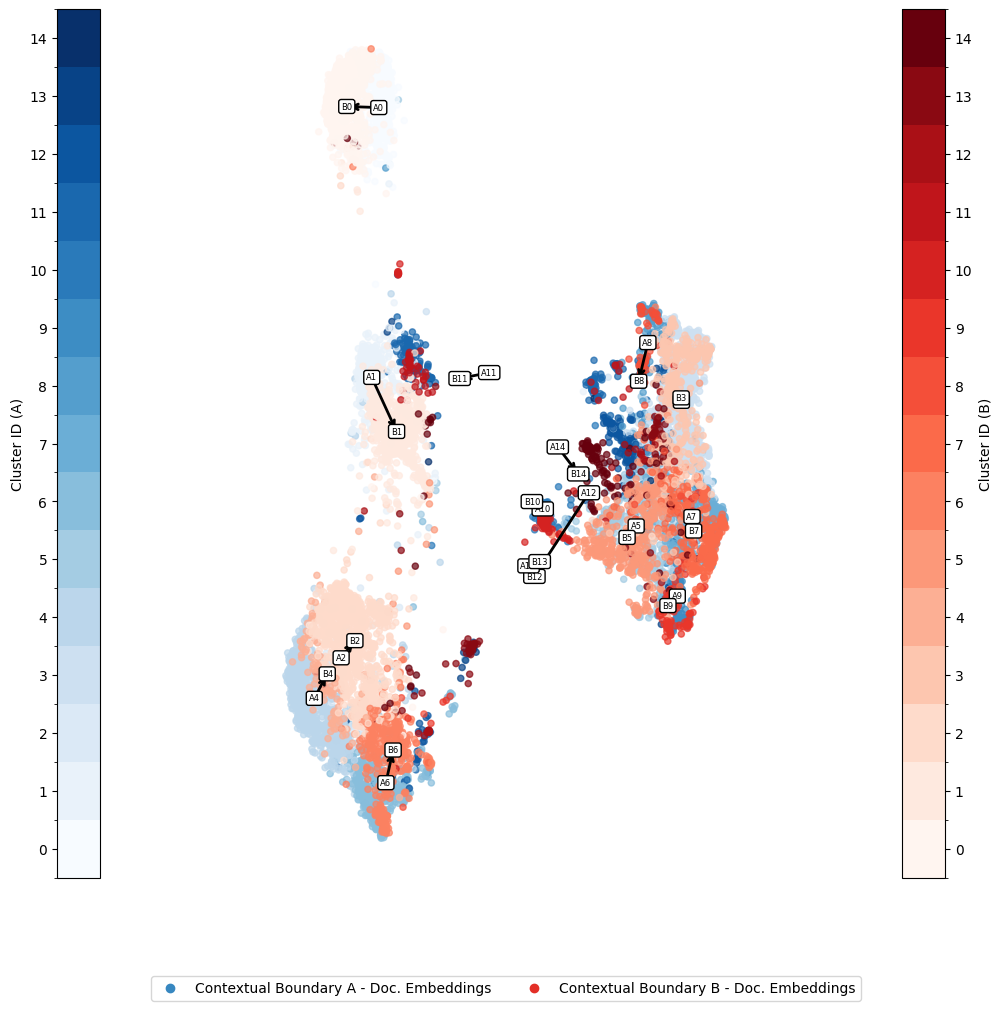

In [18]:
fig, ax = topol_model.visualize(label_col="label")
fig.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_default_topol_clusters.pdf"), format="pdf", bbox_inches='tight')
plt.show(fig, ax)

### Randomized contextual boundary analysis

In [19]:
random_cb0_cluster_info, random_cb1_cluster_info = topol_model.get_cluster_info(label_col="random_label")

In [20]:
random_cb0_cluster_info

cluster,size,avg_prob,centroid,reduced_centroid,2D_centroid,cosine_dispersion,l2_dispersion,dot_product_dispersion
i32,i32,f64,"array[f64, 1536]","array[f64, 75]","array[f64, 2]",f64,f64,f64
0,684,0.927417,"[0.007333, -0.004128, … -0.01572]","[9.955793, 5.586582, … 5.281845]","[-1.966481, 10.460533]",0.445862,0.831198,0.692931
1,620,0.828877,"[-0.003473, 0.035765, … -0.004405]","[9.481641, 5.579504, … 5.638485]","[-1.314244, 7.165918]",0.469874,0.846489,0.718966
2,563,0.723315,"[0.00933, 0.022581, … -0.006331]","[9.504569, 3.865609, … 5.778263]","[-2.035896, 4.57454]",0.488982,0.85835,0.73886
3,531,0.731573,"[-0.012385, 0.00274, … 0.004243]","[5.667916, 5.0083, … 5.709815]","[5.458251, 7.227038]",0.493234,0.860836,0.743188
4,548,0.739795,"[0.002729, 0.039914, … -0.002331]","[9.687581, 3.91522, … 5.854513]","[-2.904183, 3.971125]",0.430576,0.819649,0.675757
…,…,…,…,…,…,…,…,…
10,135,0.770909,"[-0.002118, 0.024393, … 0.010262]","[7.239358, 4.885887, … 5.710113]","[2.102992, 6.098938]",0.436007,0.823434,0.681912
11,120,0.609342,"[-0.009059, 0.015749, … -0.004512]","[8.208794, 5.344644, … 5.635577]","[0.983221, 7.509635]",0.415691,0.809849,0.658583
12,126,0.518425,"[0.000307, 0.004178, … 0.002875]","[6.640985, 4.513895, … 5.690778]","[3.020559, 6.053601]",0.482498,0.853964,0.732191


In [21]:
random_cb1_cluster_info

cluster,size,avg_prob,centroid,reduced_centroid,2D_centroid,cosine_dispersion,l2_dispersion,dot_product_dispersion
i32,i32,f64,"array[f64, 1536]","array[f64, 75]","array[f64, 2]",f64,f64,f64
0,720,0.920308,"[0.009522, -0.003163, … -0.016004]","[9.946634, 5.601147, … 5.282908]","[-1.936186, 10.47565]",0.448181,0.83255,0.695496
1,560,0.830678,"[-0.004862, 0.036165, … -0.00435]","[9.485884, 5.587631, … 5.640099]","[-1.338685, 7.158724]",0.462875,0.841835,0.711497
2,553,0.74125,"[0.009473, 0.022586, … -0.005659]","[9.53519, 3.858632, … 5.779507]","[-2.065209, 4.601567]",0.484351,0.855737,0.734106
3,557,0.755125,"[-0.011648, 0.004442, … 0.002723]","[5.673078, 4.997327, … 5.709455]","[5.50716, 7.259075]",0.485807,0.856379,0.735606
4,495,0.753039,"[0.002301, 0.038598, … -0.001961]","[9.698476, 3.973378, … 5.849475]","[-2.964994, 4.021904]",0.431092,0.819879,0.676344
…,…,…,…,…,…,…,…,…
10,115,0.785413,"[0.001631, 0.019724, … 0.012303]","[7.133936, 4.899038, … 5.711853]","[2.261228, 6.068548]",0.436046,0.823661,0.681956
11,116,0.592404,"[-0.004605, 0.02131, … -0.004648]","[8.306885, 5.379065, … 5.628694]","[0.859206, 7.557454]",0.416009,0.80932,0.658955
12,100,0.511615,"[0.003422, 0.004715, … 0.00244]","[6.436465, 4.544921, … 5.682126]","[3.36386, 6.136838]",0.461767,0.841349,0.710305


Drift computed successfully, ready to visualize.


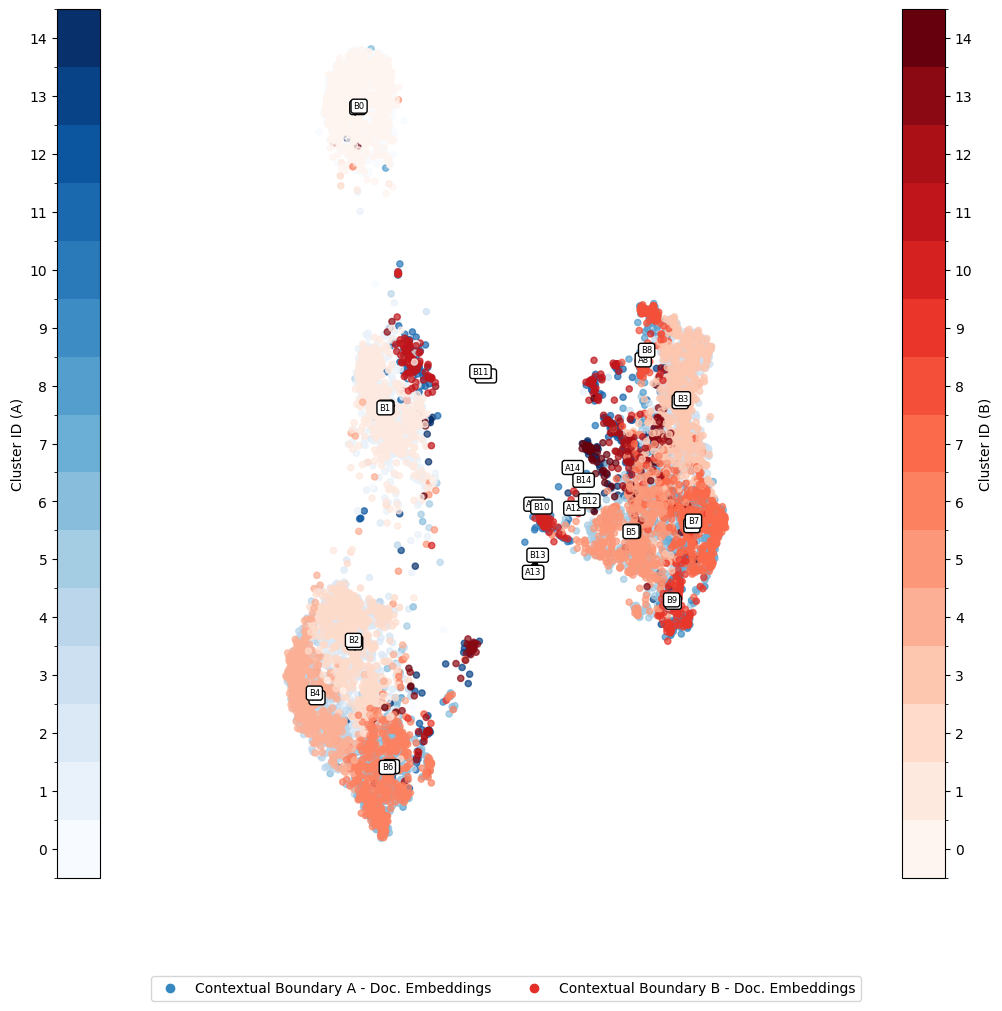

In [22]:
fig, ax = topol_model.visualize(label_col="random_label")
fig.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_random_cb_topol_clusters.pdf"), format="pdf", bbox_inches='tight')
plt.show(fig, ax)

### Drift analysis

In [23]:
assert cb0_cluster_info["cluster"].to_list() == cb1_cluster_info["cluster"].to_list(), "Cluster IDs are not the same for C.B.-0 and C.B.-1"
clusters = cb0_cluster_info["cluster"].to_list()

In [25]:
drifts_default = {}
for cluster_id, cb0_centroid, cb1_centroid in zip(clusters, cb0_cluster_info["centroid"].to_list(), cb1_cluster_info["centroid"].to_list()):
    drifts_default[cluster_id] = np.array(cb1_centroid) - np.array(cb0_centroid)

In [26]:
pairwise_drift_similarity = cosine_similarity(
    np.stack(list(drifts_default.values())), 
    np.stack(list(drifts_default.values()))
)
# pairwise_drift_similarity = pd.DataFrame(np.triu(pairwise_drift_similarity, k=1))
triu_indices = np.triu_indices(pairwise_drift_similarity.shape[0], k=1)
pairwise_drift_similarity = pairwise_drift_similarity[triu_indices[0], triu_indices[1]]

pairwise_drift_similarity.min(), pairwise_drift_similarity.mean(), pairwise_drift_similarity.max()

(np.float64(0.24326427163970948),
 np.float64(0.6488926072664768),
 np.float64(0.9133521917002404))

In [27]:
drift_norms = np.linalg.norm(np.stack(list(drifts_default.values())), axis=1)
drift_norms.min(), drift_norms.mean(), drift_norms.max()

(np.float64(0.21305866079384245),
 np.float64(0.33060685160951686),
 np.float64(0.5873063298469322))

In [29]:
drifts_random_cb = {}
for cluster_id, cb0_centroid, cb1_centroid in zip(clusters, random_cb0_cluster_info["centroid"].to_list(), random_cb1_cluster_info["centroid"].to_list()):
    drifts_random_cb[cluster_id] = np.array(cb1_centroid) - np.array(cb0_centroid)

In [30]:
pairwise_drift_similarity = cosine_similarity(
    np.stack(list(drifts_random_cb.values())), 
    np.stack(list(drifts_random_cb.values()))
)
# pairwise_drift_similarity = pd.DataFrame(np.triu(pairwise_drift_similarity, k=1))
triu_indices = np.triu_indices(pairwise_drift_similarity.shape[0], k=1)
pairwise_drift_similarity = pairwise_drift_similarity[triu_indices[0], triu_indices[1]]

pairwise_drift_similarity.min(), pairwise_drift_similarity.mean(), pairwise_drift_similarity.max()

(np.float64(-0.15105031959483028),
 np.float64(-0.0059378189461832),
 np.float64(0.13600650543933016))

In [31]:
drift_norms = np.linalg.norm(np.stack(list(drifts_random_cb.values())), axis=1)
drift_norms.min(), drift_norms.mean(), drift_norms.max()

(np.float64(0.04304304464016779),
 np.float64(0.08085565955564601),
 np.float64(0.13470001654952618))

In [32]:
drift_similarities = {}
for cluster_id in clusters:
    drift_default = drifts_default[cluster_id]
    drift_random = drifts_random_cb[cluster_id]
    norm_ratio = np.linalg.norm(drift_default) / np.linalg.norm(drift_random)
    similarity = cosine_similarity([drift_default], [drift_random])[0][0]
    dot_prod = np.dot(drift_default, drift_random)
    drift_similarities[cluster_id] = {
        "cosine_similarity": similarity,
        "dot_product": dot_prod,
        "norm_ratio": norm_ratio
    }
pd.DataFrame(drift_similarities).T

,cosine_similarity,dot_product,norm_ratio
0,-0.209699,-0.002843,7.317971
1,-0.252651,-0.004653,7.218807
2,0.107877,0.001103,4.438833
3,-0.289112,-0.005167,5.763497
4,0.020957,0.000278,4.284421
5,0.296434,0.005578,5.185589
6,0.057928,0.001002,5.912434
7,-0.229616,-0.004801,4.869202
8,-0.177721,-0.006830,3.337127
9,-0.201507,-0.006552,3.515778


4.512689420024199 1.4778002134224335


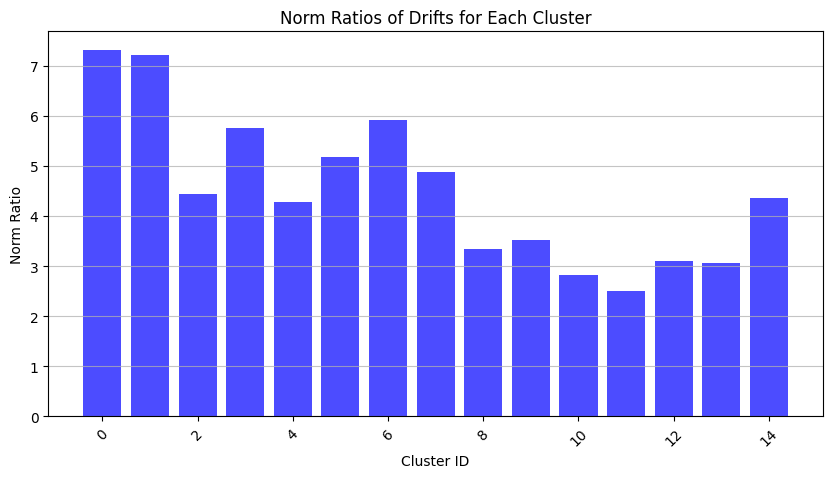

In [33]:
norm_ratios = [drift_similarities[cluster_id]["norm_ratio"] for cluster_id in clusters]
plt.figure(figsize=(10, 5))
plt.bar(clusters, norm_ratios, color='blue', alpha=0.7)
plt.xlabel('Cluster ID')
plt.ylabel('Norm Ratio')
plt.title('Norm Ratios of Drifts for Each Cluster')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
# plt.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_norm_ratios.pdf"), format="pdf", bbox_inches='tight')
print(np.mean(norm_ratios), np.std(norm_ratios))
plt.show()

In [34]:
# Norm ratio entropy
norm_ratios = np.array(norm_ratios)
norm_ratios = norm_ratios / np.sum(norm_ratios)
norm_ratio_entropy = -np.sum(norm_ratios * np.log(norm_ratios + 1e-10)) / np.log(len(norm_ratios))  # Adding a small value to avoid log(0) and normalizing by log(len(norm_ratios))
print(f"Norm Ratio Entropy: {norm_ratio_entropy}")

Norm Ratio Entropy: 0.9806525337703456


### Comparing with sentiment

In [35]:
cb0_df = topol_model.df.filter(pl.col("label") == 0)
sentiment_cb0_cluster_info = cb0_df.group_by("cluster")\
    .map_groups(lambda group: pl.DataFrame({
        "cluster": group["cluster"][0],
        "sentiment_score_finbert": np.mean(group["sentiment_score_finbert"].to_list(), axis=0),
        "sentiment_score_distilbert": np.mean(group["sentiment_score_distilbert"].to_list(), axis=0),
    }))
sentiment_cb0_cluster_info.mean()

cluster,sentiment_score_finbert,sentiment_score_distilbert
f64,f64,f64
7.0,-0.24768,-0.361769


In [36]:
cb1_df = topol_model.df.filter(pl.col("label") == 1)
sentiment_cb1_cluster_info = cb1_df.group_by("cluster")\
    .map_groups(lambda group: pl.DataFrame({
        "cluster": group["cluster"][0],
        "sentiment_score_finbert": np.mean(group["sentiment_score_finbert"].to_list(), axis=0),
        "sentiment_score_distilbert": np.mean(group["sentiment_score_distilbert"].to_list(), axis=0),
    }))
sentiment_cb1_cluster_info.mean()

cluster,sentiment_score_finbert,sentiment_score_distilbert
f64,f64,f64
7.0,0.075027,0.536281


In [37]:
random_cb0_df = topol_model.df.filter(pl.col("random_label") == 0)
random_sentiment_cb0_cluster_info = random_cb0_df.group_by("cluster")\
    .map_groups(lambda group: pl.DataFrame({
        "cluster": group["cluster"][0],
        "sentiment_score_finbert": np.mean(group["sentiment_score_finbert"].to_list(), axis=0),
        "sentiment_score_distilbert": np.mean(group["sentiment_score_distilbert"].to_list(), axis=0),
    }))
random_sentiment_cb0_cluster_info.mean()

cluster,sentiment_score_finbert,sentiment_score_distilbert
f64,f64,f64
7.0,-0.096111,0.083552


In [38]:
random_cb1_df = topol_model.df.filter(pl.col("random_label") == 1)
random_sentiment_cb1_cluster_info = random_cb1_df.group_by("cluster")\
    .map_groups(lambda group: pl.DataFrame({
        "cluster": group["cluster"][0],
        "sentiment_score_finbert": np.mean(group["sentiment_score_finbert"].to_list(), axis=0),
        "sentiment_score_distilbert": np.mean(group["sentiment_score_distilbert"].to_list(), axis=0),
    }))
random_sentiment_cb1_cluster_info.mean()

cluster,sentiment_score_finbert,sentiment_score_distilbert
f64,f64,f64
7.0,-0.096973,0.066513


### Quality metrics

In [39]:
cb0_cluster_info[["size", "avg_prob", "cosine_dispersion", "l2_dispersion", "dot_product_dispersion"]].mean()

size,avg_prob,cosine_dispersion,l2_dispersion,dot_product_dispersion
f64,f64,f64,f64,f64
333.333333,0.662218,0.428775,0.816306,0.671062


In [40]:
random_cb0_cluster_info[["size", "avg_prob", "cosine_dispersion", "l2_dispersion", "dot_product_dispersion"]].mean()

size,avg_prob,cosine_dispersion,l2_dispersion,dot_product_dispersion
f64,f64,f64,f64,f64
333.333333,0.695234,0.469647,0.845445,0.717702


In [41]:
cb1_cluster_info[["size", "avg_prob", "cosine_dispersion", "l2_dispersion", "dot_product_dispersion"]].mean()

size,avg_prob,cosine_dispersion,l2_dispersion,dot_product_dispersion
f64,f64,f64,f64,f64
333.333333,0.6759,0.467726,0.844304,0.715813


In [42]:
random_cb1_cluster_info[["size", "avg_prob", "cosine_dispersion", "l2_dispersion", "dot_product_dispersion"]].mean()

size,avg_prob,cosine_dispersion,l2_dispersion,dot_product_dispersion
f64,f64,f64,f64,f64
333.333333,0.693091,0.466358,0.843487,0.714414


### Drift explainability

In [43]:
XAI_OUTPUTS_PATH = os.path.join(OUTPUTS_PATH, "explainability")

##### NRC-VAD Clusters based analysis

In [44]:
XAI1_PATH = os.path.join(XAI_OUTPUTS_PATH, "nrc_vad_clusters")

In [45]:
version = "v2.1"  # "v1.0" or "v2.1"
fbase = "NRC-VAD-Lexicon-" + version

nrc_vad_df_path = os.path.join(DATA_PATH, fbase, f"nrc_vad_lexicon_{version}.pkl")
if os.path.exists(nrc_vad_df_path):
    print(f"Loading NRC-VAD lexicon from {nrc_vad_df_path}")
    nrc_vad_df = pd.read_pickle(nrc_vad_df_path) # Pandas DataFrame
else:
    print("File not found.")

nrc_vad_df = pl.DataFrame(nrc_vad_df)

Loading NRC-VAD lexicon from /Users/tig1/Programming/TOPOL/data/NRC-VAD-Lexicon-v2.1/nrc_vad_lexicon_v2.1.pkl


In [46]:
nrc_vad_embeddings = np.stack(nrc_vad_df["embedding"].to_numpy())
nrc_vad_graph = topol_model.umap_graph.transform(nrc_vad_embeddings)
nrc_vad_adjacency_matrix = csr_matrix(nrc_vad_graph)
nrc_vad_reduced_embeddings = topol_model.umap_dim_reducer.transform(nrc_vad_embeddings)

leiden = Leiden(resolution=2.0, modularity='dugue', random_state=RANDOM_STATE)
leiden.fit(nrc_vad_adjacency_matrix)
nrc_vad_labels = leiden.fit_predict(nrc_vad_adjacency_matrix)
nrc_vad_probs = [probs[cluster_id] for cluster_id, probs in zip(nrc_vad_labels, leiden.predict_proba(False))]

nrc_vad_df = nrc_vad_df.with_columns(
    pl.Series("reduced_embedding", nrc_vad_reduced_embeddings.tolist()),
    pl.Series("cluster", nrc_vad_labels),
    pl.Series("cluster_prob", nrc_vad_probs),
)

In [47]:
nrcvad_cluster_info = (
    nrc_vad_df.group_by("cluster")
    .map_groups(lambda group: pl.DataFrame({
        "cluster": group["cluster"][0],
        "avg_prob": [np.mean(group["cluster_prob"].to_list())],
        "cluster_size": group.height,
        "terms": [group["term"]],
        "centroid": [np.mean(group["embedding"].to_list(), axis=0)],
        "reduced_centroid": [np.mean(group["reduced_embedding"].to_list(), axis=0)],
        "avg_valence": group["valence"].mean(),
        "avg_arousal": group["arousal"].mean(),
        "avg_dominance": group["dominance"].mean(),
    }))
)
nrcvad_cluster_info = nrcvad_cluster_info.sort("cluster")

In [48]:
nrcvad_centroids = np.stack(nrcvad_cluster_info["centroid"].to_numpy())
nrcvad_centroids.shape

(26, 1536)

HoTL proposed contextual boundary

In [49]:
closest_nrc_vad_cluster_ids = []
valence_values = []
arousal_values = []
dominance_values = []
for row in cb0_cluster_info.iter_rows(named=True):
    centroid = row["centroid"]
    similarities = cosine_similarity([centroid], nrcvad_centroids)[0]
    closest_nrc_vad_cluster_id = int(np.argmax(similarities))
    closest_nrc_vad_cluster_ids.append(closest_nrc_vad_cluster_id)
    nrc_vad_row = nrcvad_cluster_info.filter(pl.col("cluster") == closest_nrc_vad_cluster_id).to_pandas().iloc[0]
    valence_values.append(nrc_vad_row["avg_valence"])
    arousal_values.append(nrc_vad_row["avg_arousal"])
    dominance_values.append(nrc_vad_row["avg_dominance"])

cb0_cluster_info = cb0_cluster_info.with_columns(
    pl.Series("closest_nrc_vad_cluster_id", closest_nrc_vad_cluster_ids),
    pl.Series("valence", valence_values, dtype=pl.Float64),
    pl.Series("arousal", arousal_values, dtype=pl.Float64),
    pl.Series("dominance", dominance_values, dtype=pl.Float64)
)

In [50]:
closest_nrc_vad_cluster_ids = []
valence_values = []
arousal_values = []
dominance_values = []
for row in cb1_cluster_info.iter_rows(named=True):
    centroid = row["centroid"]
    similarities = cosine_similarity([centroid], nrcvad_centroids)[0]
    closest_nrc_vad_cluster_id = int(np.argmax(similarities))
    closest_nrc_vad_cluster_ids.append(closest_nrc_vad_cluster_id)
    nrc_vad_row = nrcvad_cluster_info.filter(pl.col("cluster") == closest_nrc_vad_cluster_id).to_pandas().iloc[0]
    valence_values.append(nrc_vad_row["avg_valence"])
    arousal_values.append(nrc_vad_row["avg_arousal"])
    dominance_values.append(nrc_vad_row["avg_dominance"])

cb1_cluster_info = cb1_cluster_info.with_columns(
    pl.Series("closest_nrc_vad_cluster_id", closest_nrc_vad_cluster_ids),
    pl.Series("valence", valence_values, dtype=pl.Float64),
    pl.Series("arousal", arousal_values, dtype=pl.Float64),
    pl.Series("dominance", dominance_values, dtype=pl.Float64)
)

In [51]:
cb0_cluster_info[["valence", "arousal", "dominance"]].mean()

valence,arousal,dominance
f64,f64,f64
-0.151909,0.039638,-0.062008


In [52]:
cb1_cluster_info[["valence", "arousal", "dominance"]].mean()

valence,arousal,dominance
f64,f64,f64
0.133206,0.007154,0.063968


<Axes: >

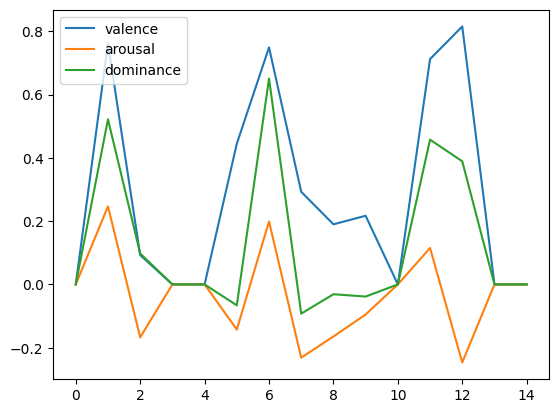

In [53]:
(cb1_cluster_info[["valence", "arousal", "dominance"]] - cb0_cluster_info[["valence", "arousal", "dominance"]]).to_pandas().plot()

In [54]:
cb0_cluster_info["closest_nrc_vad_cluster_id"].unique().to_list(), cb1_cluster_info["closest_nrc_vad_cluster_id"].unique().to_list()

([0, 1, 3, 5, 7, 13, 18, 23, 24, 25], [0, 1, 2, 5, 8, 12, 13, 14, 18, 19, 24])

Random contextual boundary

In [55]:
closest_nrc_vad_cluster_ids = []
valence_values = []
arousal_values = []
dominance_values = []
for row in random_cb0_cluster_info.iter_rows(named=True):
    centroid = row["centroid"]
    similarities = cosine_similarity([centroid], nrcvad_centroids)[0]
    closest_nrc_vad_cluster_id = int(np.argmax(similarities))
    closest_nrc_vad_cluster_ids.append(closest_nrc_vad_cluster_id)
    nrc_vad_row = nrcvad_cluster_info.filter(pl.col("cluster") == closest_nrc_vad_cluster_id).to_pandas().iloc[0]
    valence_values.append(nrc_vad_row["avg_valence"])
    arousal_values.append(nrc_vad_row["avg_arousal"])
    dominance_values.append(nrc_vad_row["avg_dominance"])

random_cb0_cluster_info = random_cb0_cluster_info.with_columns(
    pl.Series("closest_nrc_vad_cluster_id", closest_nrc_vad_cluster_ids),
    pl.Series("valence", valence_values, dtype=pl.Float64),
    pl.Series("arousal", arousal_values, dtype=pl.Float64),
    pl.Series("dominance", dominance_values, dtype=pl.Float64)
)

In [56]:
closest_nrc_vad_cluster_ids = []
valence_values = []
arousal_values = []
dominance_values = []
for row in random_cb1_cluster_info.iter_rows(named=True):
    centroid = row["centroid"]
    similarities = cosine_similarity([centroid], nrcvad_centroids)[0]
    closest_nrc_vad_cluster_id = int(np.argmax(similarities))
    closest_nrc_vad_cluster_ids.append(closest_nrc_vad_cluster_id)
    nrc_vad_row = nrcvad_cluster_info.filter(pl.col("cluster") == closest_nrc_vad_cluster_id).to_pandas().iloc[0]
    valence_values.append(nrc_vad_row["avg_valence"])
    arousal_values.append(nrc_vad_row["avg_arousal"])
    dominance_values.append(nrc_vad_row["avg_dominance"])

random_cb1_cluster_info = random_cb1_cluster_info.with_columns(
    pl.Series("closest_nrc_vad_cluster_id", closest_nrc_vad_cluster_ids),
    pl.Series("valence", valence_values, dtype=pl.Float64),
    pl.Series("arousal", arousal_values, dtype=pl.Float64),
    pl.Series("dominance", dominance_values, dtype=pl.Float64)
)

In [57]:
random_cb0_cluster_info[["valence", "arousal", "dominance"]].mean()

valence,arousal,dominance
f64,f64,f64
-0.027053,0.050172,0.000251


In [58]:
random_cb1_cluster_info[["valence", "arousal", "dominance"]].mean()

valence,arousal,dominance
f64,f64,f64
-0.00753,0.034734,-0.005907


<Axes: >

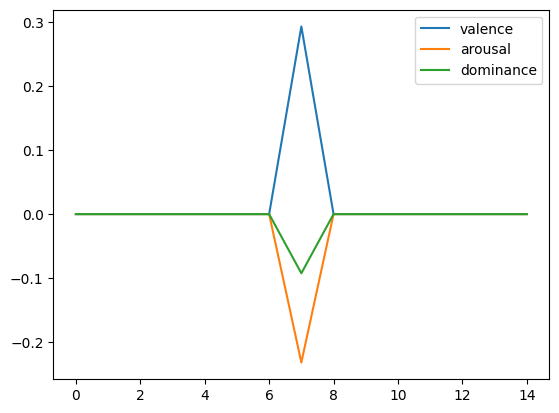

In [59]:
(random_cb1_cluster_info[["valence", "arousal", "dominance"]] - random_cb0_cluster_info[["valence", "arousal", "dominance"]]).to_pandas().plot()

In [60]:
random_cb0_cluster_info["closest_nrc_vad_cluster_id"].unique().to_list(), random_cb1_cluster_info["closest_nrc_vad_cluster_id"].unique().to_list()

([0, 1, 2, 5, 7, 8, 13, 14, 18, 21, 23, 24, 25],
 [0, 1, 2, 5, 8, 13, 14, 18, 21, 23, 24, 25])

##### LLM-Generated Approach

In [61]:
assert False

AssertionError: 

In [ ]:
XAI2_PATH = os.path.join(XAI_OUTPUTS_PATH, "llm_generated")

In [ ]:
fpath = os.path.join(DATA_PATH, "prompt_template.txt")
if os.path.exists(fpath):
    with open(fpath, "r") as f:
        PROMPT_TEMPLATE = f.read()
    print(f"Loaded prompt template from {fpath}")
else:
    raise FileNotFoundError(f"Prompt template file not found at {fpath}")
del fpath

Loaded prompt template from /Users/tig1/Programming/TOPOL/data/prompt_template.txt


In [ ]:
def generate_narrative_comparison_prompt(text1, text2):
    prompt = PROMPT_TEMPLATE.replace("#####TEXT1#####", text1)
    prompt = prompt.replace("#####TEXT2#####", text2)
    return prompt

In [ ]:
# chat_completion_func, model_name = openai_chat_completion, "gpt-4o-mini-2024-07-18"
chat_completion_func, model_name = google_chat_completion, "gemini-2.0-flash"

text_generation_params = {
    "model": model_name,
    "temperature": 0.1,
    "top_p": 1.0,
    # "presence_penalty": 0.0,
    # "frequency_penalty": 0.0,
    "max_tokens": 1000000,
}

K = 5  # Number of top documents to retrieve for each cluster

HoTL proposed contextual boundary

In [ ]:
cb0_df = topol_model.df.filter(pl.col("label") == 0).clone()
top_k_docs = get_top_k_representative_docs(cb0_cluster_info, cb0_df, k=K)
cb0_cluster_info = cb0_cluster_info.join(top_k_docs, on="cluster", how="left")

In [ ]:
cb1_df = topol_model.df.filter(pl.col("label") == 1).clone()
top_k_docs = get_top_k_representative_docs(cb1_cluster_info, cb1_df, k=K)
cb1_cluster_info = cb1_cluster_info.join(top_k_docs, on="cluster", how="left")

In [ ]:
for cluster_id in tqdm(clusters, desc="Processing clusters"):
    cb0_row = cb0_cluster_info.filter(pl.col("cluster") == cluster_id).to_dicts()[0]
    cb1_row = cb1_cluster_info.filter(pl.col("cluster") == cluster_id).to_dicts()[0]

    # Generate the prompt for the LLM
    text1 = from_list_to_string(cb0_row["top_docs"])
    text2 = from_list_to_string(cb1_row["top_docs"])
    prompt = generate_narrative_comparison_prompt(text1, text2)
    response = chat_completion_func(prompt, **text_generation_params)

    # Parse the JSON response safely
    parsed_llm_out = safe_json_load(response)

    # Save to file
    fname = f"{FILES_PREFIX}_HoTL_cluster_{cluster_id}.json"
    fpath = os.path.join(XAI2_PATH, fname)
    with open(fpath, "w", encoding="utf-8") as f:
        json.dump(parsed_llm_out, f, ensure_ascii=False, indent=2)

Processing clusters:   0%|          | 0/15 [00:00<?, ?it/s]

Response: ```json
[
  {
    "dimension_title": "Disappointment to Appreciation",
    "text1_sentence_count": 2,
    "text2_sentence_count": 2,
    "confidence_label_text1": "High",
    "confidence_label_text2": "High",
    "confidence_score_text1": 40,
    "confidence_score_text2": 40,
    "text1_evidence_sentences": [
      "Very disappointing to me I am a very, very big Elliott Smith fan and have been for DATE, the kind who has every recording, live, bootleg, videos of him playing, saw him live, read his biography, etc.",
      "I am selling my copy of this album without even ripping it because there isn't a single song on it that does anything new with the music or is in any way better than the originals."
    ],
    "text2_evidence_sentences": [
      "Like any treasure, must be heard to be appreciated.",
      "I was pleasantly surprised, though, with the rest of the work."
    ],
    "text1_keywords": ["disappointing", "Waste of time, waste of money"],
    "text2_keywords": ["tre

Random contextual boundary

In [ ]:
random_cb0_df = topol_model.df.filter(pl.col("random_label") == 0).clone()
top_k_docs = get_top_k_representative_docs(random_cb0_cluster_info, random_cb0_df, k=K)
random_cb0_cluster_info = random_cb0_cluster_info.join(top_k_docs, on="cluster", how="left")

In [ ]:
random_cb1_df = topol_model.df.filter(pl.col("random_label") == 1).clone()
top_k_docs = get_top_k_representative_docs(random_cb1_cluster_info, random_cb1_df, k=K)
random_cb1_cluster_info = random_cb1_cluster_info.join(top_k_docs, on="cluster", how="left")

In [ ]:
for cluster_id in tqdm(clusters, desc="Processing random clusters"):
    cb0_row = random_cb0_cluster_info.filter(pl.col("cluster") == cluster_id).to_dicts()[0]
    cb1_row = random_cb1_cluster_info.filter(pl.col("cluster") == cluster_id).to_dicts()[0]

    # Generate the prompt for the LLM
    text1 = from_list_to_string(cb0_row["top_docs"])
    text2 = from_list_to_string(cb1_row["top_docs"])
    prompt = generate_narrative_comparison_prompt(text1, text2)
    response = chat_completion_func(prompt, **text_generation_params)

    # Parse the JSON response safely
    parsed_llm_out = safe_json_load(response)

    # Save to file
    fname = f"{FILES_PREFIX}_random_cluster_{cluster_id}.json"
    fpath = os.path.join(XAI2_PATH, fname)
    with open(fpath, "w", encoding="utf-8") as f:
        json.dump(parsed_llm_out, f, ensure_ascii=False, indent=2)

Processing random clusters:   0%|          | 0/15 [00:00<?, ?it/s]

Response: ```json
[
  {
    "dimension_title": "Harsh Criticism to Qualified Appreciation",
    "text1_sentence_count": 2,
    "text2_sentence_count": 2,
    "confidence_label_text1": "High",
    "confidence_label_text2": "Medium",
    "confidence_score_text1": 40,
    "confidence_score_text2": 40,
    "text1_evidence_sentences": [
      "Songs that are plain awful are 'Bomb', 'Testosterone', 'Monkey', and 'Alien'.",
      "The rest of the CD isn't anything I want to listen to."
    ],
    "text2_evidence_sentences": [
      "OK but not Gods gift.",
      "About half of this cd is quite good."
    ],
    "text1_keywords": ["plain awful", "Steer clear"],
    "text2_keywords": ["not Gods gift", "quite good"]
  },
  {
    "dimension_title": "Focus on Individual Songs to Album Experience",
    "text1_sentence_count": 2,
    "text2_sentence_count": 2,
    "confidence_label_text1": "Medium",
    "confidence_label_text2": "High",
    "confidence_score_text1": 40,
    "confidence_score_text2":

In [ ]:
print(prompt)

Role: You are a semantic narrative analyst. Your task is to identify all strong, directional narrative polarity dimensions that differentiate text1 from text2. These dimensions represent conceptual shifts in discourse (e.g., tone, stance, topic, moral framing) and must be grounded in explicit sentence-level evidence from both texts.

Each dimension should reflect a transition from a pole dominant in text1 to a different pole dominant in text2. Only report a dimension if it meets all of the following criteria:

1. It is clearly directional (text1 → text2). Symmetric or bidirectional contrasts are invalid.
2. It is supported by at least two sentences from text1 and two from text2 that express the respective poles. Each "sentence" refers to a distinct, declarative statement.
3. The keywords and evidence sentences must clearly match the claimed direction of the shift. For completeness, to the extent of possible, provide keywords different from those contained in evidence sentences.
4. All 

In [ ]:
print(response)

```json
[
  {
    "dimension_title": "Disappointment to Enjoyment",
    "text1_sentence_count": 2,
    "text2_sentence_count": 2,
    "confidence_label_text1": "High",
    "confidence_label_text2": "High",
    "confidence_score_text1": 40,
    "confidence_score_text2": 40,
    "text1_evidence_sentences": [
      "I was looking forward to it but was very disappointed.",
      "This DVD did not hold my attention and was NOT it a good work out."
    ],
    "text2_evidence_sentences": [
      "The aerobics section of this video is beginner/intermediate level and great!",
      "It's fun and Karen is an excellent instructor."
    ],
    "text1_keywords": ["very disappointed", "thumbs down"],
    "text2_keywords": ["is great", "still enjoy"]
  },
  {
    "dimension_title": "Boredom to Engagement",
    "text1_sentence_count": 2,
    "text2_sentence_count": 2,
    "confidence_label_text1": "High",
    "confidence_label_text2": "High",
    "confidence_score_text1": 40,
    "confidence_score_tex